In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.loaders import load_mat_spike_data, print_data_summary
from src.generators import (
    homogeneous_poisson,
    homogeneous_poisson_with_refractoriness,
    interspike_intervals
)
from src.analysis import (
    coefficient_of_variation,
    fano_factor,
    isi_histogram,
    firing_rate_estimate
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All imports successful!")

# Load real data
print("\n" + "="*70)
print("LOADING REAL H1 NEURON DATA")
print("="*70)

spike_times_real, stimulus, metadata = load_mat_spike_data(
    '../data/raw/c1p8.mat',
    sampling_rate=1000.0
)

print_data_summary(spike_times_real, metadata)

real_firing_rate = metadata['firing_rate']
real_duration = metadata['duration']


✓ All imports successful!

LOADING REAL H1 NEURON DATA
NEURAL RECORDING SUMMARY

File: ../data/raw/c1p8.mat
Duration: 600.0 seconds (10.00 minutes)
Sampling rate: 1000 Hz
Total samples: 600000

Spike Statistics:
  Total spikes: 53601
  Firing rate: 89.3 Hz
  Spike time range: 0.0170 to 599.9470 s

Interspike Interval Statistics:
  Mean ISI: 11.193 ms
  Min ISI: 1.000 ms
  Max ISI: 304.000 ms
  Median ISI: 4.000 ms


In [2]:
print("\n" + "="*70)
print("REAL DATA ANALYSIS")
print("="*70)

isis_real = interspike_intervals(spike_times_real)
cv_real = coefficient_of_variation(spike_times_real)

print(f"\nCoefficient of Variation (CV):")
print(f"  Real neuron: {cv_real:.4f}")
print(f"  Interpretation: {'MORE' if cv_real < 1.0 else 'LESS'} regular than Poisson")

print(f"\nInterspike Interval (ISI) Statistics:")
print(f"  Mean: {np.mean(isis_real)*1000:.3f} ms")
print(f"  Min: {np.min(isis_real)*1000:.3f} ms")
print(f"  Max: {np.max(isis_real)*1000:.3f} ms")

# Fano factor at key scales
ff_01s = fano_factor(spike_times_real, real_duration, 0.01)
ff_1s = fano_factor(spike_times_real, real_duration, 1.0)

print(f"\nFano Factor:")
print(f"  @ 10ms: {ff_01s:.4f}")
print(f"  @ 1s:   {ff_1s:.4f}")


REAL DATA ANALYSIS

Coefficient of Variation (CV):
  Real neuron: 2.0086
  Interpretation: LESS regular than Poisson

Interspike Interval (ISI) Statistics:
  Mean: 11.193 ms
  Min: 1.000 ms
  Max: 304.000 ms

Fano Factor:
  @ 10ms: 1.6958
  @ 1s:   7.1036


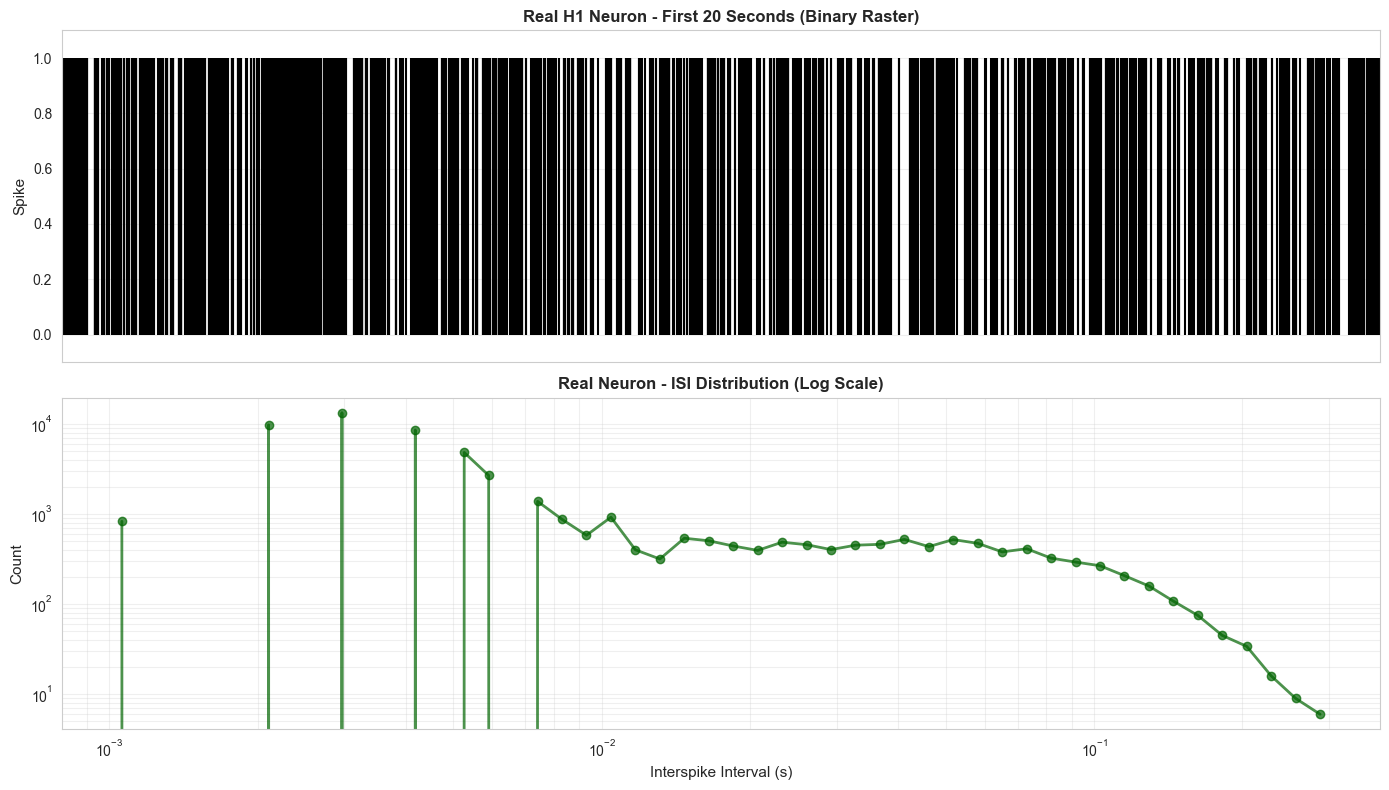


✓ Real data visualization complete!


In [3]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Raster (first 20 seconds)
ax = axes[0]
first_20s = spike_times_real[spike_times_real < 20]
ax.vlines(first_20s, 0, 1, colors='black', linewidth=1.5)
ax.set_xlim(0, 20)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel('Spike', fontsize=11)
ax.set_title('Real H1 Neuron - First 20 Seconds (Binary Raster)', fontsize=12, fontweight='bold')
ax.set_xticks([])
ax.grid(True, alpha=0.3)

# Plot 2: ISI histogram (log scale)
ax = axes[1]
hist, edges = isi_histogram(spike_times_real, n_bins=50, log_scale=True)
bin_centers = (edges[:-1] + edges[1:]) / 2
ax.loglog(bin_centers, hist, 'o-', linewidth=2, markersize=6, color='darkgreen', alpha=0.7)
ax.set_xlabel('Interspike Interval (s)', fontsize=11)
ax.set_ylabel('Count', fontsize=11)
ax.set_title('Real Neuron - ISI Distribution (Log Scale)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig('../figures/09_real_data_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Real data visualization complete!")

In [4]:
print("\n" + "="*70)
print("GENERATING MODEL PREDICTIONS")
print("="*70)

# Generate Poisson with same parameters as real data
print(f"\nGenerating Poisson model ({real_firing_rate:.1f} Hz, {real_duration}s)...")
spikes_poisson = homogeneous_poisson(
    firing_rate=real_firing_rate,
    duration=real_duration,
    random_seed=42
)
print(f"  Generated {len(spikes_poisson)} spikes")

# Generate Refractory with 2ms dead time
print(f"\nGenerating Refractory model (2ms refractory period)...")
spikes_refractory = homogeneous_poisson_with_refractoriness(
    firing_rate=real_firing_rate,
    duration=real_duration,
    refractory_period=0.002,
    random_seed=42
)
print(f"  Generated {len(spikes_refractory)} spikes")

# Calculate ISIs and CVs
isis_poisson = interspike_intervals(spikes_poisson)
isis_refractory = interspike_intervals(spikes_refractory)
cv_poisson = coefficient_of_variation(spikes_poisson)
cv_refractory = coefficient_of_variation(spikes_refractory)

print(f"\nModel Statistics:")
print(f"  Poisson CV: {cv_poisson:.4f}")
print(f"  Refractory CV: {cv_refractory:.4f}")
print(f"  Real CV: {cv_real:.4f}")



GENERATING MODEL PREDICTIONS

Generating Poisson model (89.3 Hz, 600.0s)...
  Generated 53548 spikes

Generating Refractory model (2ms refractory period)...
  Generated 45485 spikes

Model Statistics:
  Poisson CV: 0.9992
  Refractory CV: 0.8489
  Real CV: 2.0086


In [5]:
print("\n" + "="*70)
print("MODEL COMPARISON - COMPREHENSIVE")
print("="*70)

# Calculate Fano factors for models
ff_p_10ms = fano_factor(spikes_poisson, real_duration, 0.01)
ff_r_10ms = fano_factor(spikes_refractory, real_duration, 0.01)
ff_p_1s = fano_factor(spikes_poisson, real_duration, 1.0)
ff_r_1s = fano_factor(spikes_refractory, real_duration, 1.0)

# Create comparison table
print(f"\n{'Metric':<25} {'Poisson':<15} {'Refractory':<15} {'Real':<15}")
print("-" * 70)
print(f"{'Spike Count':<25} {len(spikes_poisson):<15} {len(spikes_refractory):<15} {len(spike_times_real):<15}")
print(f"{'Firing Rate (Hz)':<25} {len(spikes_poisson)/real_duration:<15.1f} {len(spikes_refractory)/real_duration:<15.1f} {real_firing_rate:<15.1f}")
print(f"{'CV':<25} {cv_poisson:<15.4f} {cv_refractory:<15.4f} {cv_real:<15.4f}")
print(f"{'Min ISI (ms)':<25} {np.min(isis_poisson)*1000:<15.3f} {np.min(isis_refractory)*1000:<15.3f} {np.min(isis_real)*1000:<15.3f}")
print(f"{'Mean ISI (ms)':<25} {np.mean(isis_poisson)*1000:<15.3f} {np.mean(isis_refractory)*1000:<15.3f} {np.mean(isis_real)*1000:<15.3f}")
print(f"{'FF @ 10ms':<25} {ff_p_10ms:<15.4f} {ff_r_10ms:<15.4f} {ff_01s:<15.4f}")
print(f"{'FF @ 1s':<25} {ff_p_1s:<15.4f} {ff_r_1s:<15.4f} {ff_1s:<15.4f}")

# Calculate errors
print(f"\n" + "="*70)
print("GOODNESS OF FIT ANALYSIS")
print("="*70)

cv_error_p = abs(cv_poisson - cv_real)
cv_error_r = abs(cv_refractory - cv_real)
min_isi_error_p = abs(np.min(isis_poisson) - np.min(isis_real))
min_isi_error_r = abs(np.min(isis_refractory) - np.min(isis_real))
ff10_error_p = abs(ff_p_10ms - ff_01s)
ff10_error_r = abs(ff_r_10ms - ff_01s)

print(f"\nAbsolute Errors from Real Data:")
print(f"{'Metric':<20} {'Poisson Error':<18} {'Refractory Error':<18} {'Winner':<15}")
print("-" * 71)
print(f"{'CV':<20} {cv_error_p:<18.4f} {cv_error_r:<18.4f} {'Refractory' if cv_error_r < cv_error_p else 'Poisson':<15}")
print(f"{'Min ISI (s)':<20} {min_isi_error_p:<18.6f} {min_isi_error_r:<18.6f} {'Refractory' if min_isi_error_r < min_isi_error_p else 'Poisson':<15}")
print(f"{'FF @ 10ms':<20} {ff10_error_p:<18.4f} {ff10_error_r:<18.4f} {'Refractory' if ff10_error_r < ff10_error_p else 'Poisson':<15}")

# Total error
total_error_p = cv_error_p + min_isi_error_p + ff10_error_p
total_error_r = cv_error_r + min_isi_error_r + ff10_error_r

print(f"\n{'TOTAL ERROR':<20} {total_error_p:<18.4f} {total_error_r:<18.4f} {'REFRACTORY' if total_error_r < total_error_p else 'POISSON':<15}")

if total_error_r < total_error_p:
    improvement = ((total_error_p - total_error_r) / total_error_p) * 100
    print(f"\n✓ REFRACTORY MODEL FITS BETTER by {improvement:.1f}%")
else:
    improvement = ((total_error_r - total_error_p) / total_error_r) * 100
    print(f"\n✓ POISSON MODEL FITS BETTER by {improvement:.1f}%")




MODEL COMPARISON - COMPREHENSIVE

Metric                    Poisson         Refractory      Real           
----------------------------------------------------------------------
Spike Count               53548           45485           53601          
Firing Rate (Hz)          89.2            75.8            89.3           
CV                        0.9992          0.8489          2.0086         
Min ISI (ms)              0.000           2.000           1.000          
Mean ISI (ms)             11.204          13.191          11.193         
FF @ 10ms                 0.9939          0.7385          1.6958         
FF @ 1s                   0.9786          0.6835          7.1036         

GOODNESS OF FIT ANALYSIS

Absolute Errors from Real Data:
Metric               Poisson Error      Refractory Error   Winner         
-----------------------------------------------------------------------
CV                   1.0093             1.1596             Poisson        
Min ISI (s)          

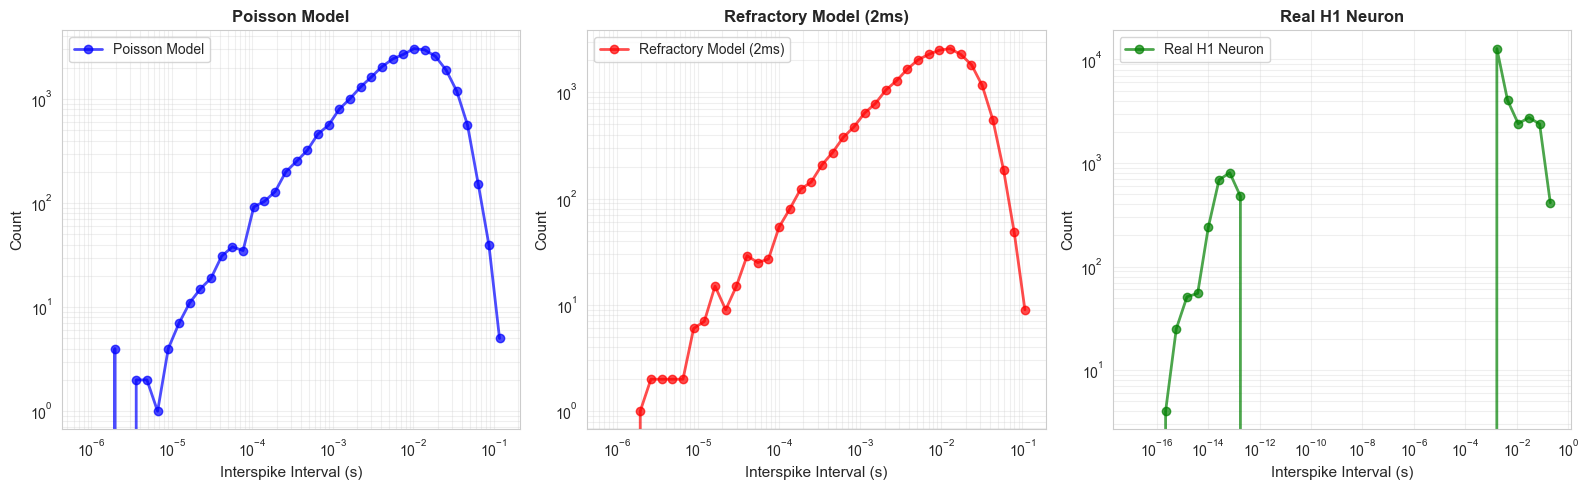


✓ ISI comparison plots complete!


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Function to plot ISI
def plot_isi(ax, isis, label, color):
    hist, edges = isi_histogram(isis, n_bins=40, log_scale=True)
    bin_centers = (edges[:-1] + edges[1:]) / 2
    ax.loglog(bin_centers, hist, 'o-', linewidth=2, markersize=6, 
              color=color, label=label, alpha=0.7)
    ax.set_xlabel('Interspike Interval (s)', fontsize=11)
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'{label}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3, which='both')

plot_isi(axes[0], isis_poisson, 'Poisson Model', 'blue')
plot_isi(axes[1], isis_refractory, 'Refractory Model (2ms)', 'red')
plot_isi(axes[2], isis_real, 'Real H1 Neuron', 'green')

plt.tight_layout()
plt.savefig('../figures/10_isi_comparison_all_models.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ ISI comparison plots complete!")